In [1]:
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import Timetable1 as tt1

In [2]:
def get_new_matches(df):
    taken_teams_list, pair_teams_list = [], []
    for i in range(df.shape[0]): 
        try:
            team_x = df["team"].iloc[i]

            if team_x not in taken_teams_list:

                taken_teams_list.append(team_x)

                # 1) Filter
                # result_last_match = df["history"].iloc[i][-1]
                # df1 = df[df["last_result"] == result_last_match]
                df1 = df.copy()

                # 2) Not same team than ALL last matches and not the self team.
                played_teams_list = df1["played_teams"].iloc[i]
                idx_to_remove_list = [df1[df1["team"] == team].index.values[0] for team in played_teams_list]
                df2 = df1.drop(idx_to_remove_list)
                df2 = df2[df2["team"] != df["team"].iloc[i]]

                # 3) Get the team
                i_iloc = 0
                while True:
                    team_y = df2["team"].iloc[i_iloc]
                    if team_y not in taken_teams_list and team_x != team_y:
                        break
                    i_iloc += 1

                pair_teams_list.append(team_x + " vs " + team_y)
                taken_teams_list.append(team_y)

        except:
            print("*** El programa no ha podido emparejar a todos los equipos ***")
            print("Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...")
            taken_teams_list, pair_teams_list = tt1.find_possible_matches(df)

    str_save_list = []
    for pair_teams_i, pair_teams in enumerate(pair_teams_list):
        team1, team2 = pair_teams.split(" vs ")
        # str_save = team1 + " - " + team2 + " ; ? - ? ; ? - ?"
        str_save = team1 + " - " + team2
        str_save_list.append(str_save)
    
    return pair_teams_list, str_save_list

def translate_dict_to_table(dict_result_new, save_all_matches_list):
    
    for line_i, line in enumerate(save_all_matches_list):
        team1, dict_help1, team2, dict_help2 = tt1.get_dicts_by_line(line)
        team_list, dict_help_list = [team1, team2], [dict_help1, dict_help2]

        for tm, dict_h in zip(team_list, dict_help_list):

            dict_result_new[tm]["played_teams"].append(dict_h["played_teams"])
            dict_result_new[tm]["history"].append(dict_h["history"])
            dict_result_new[tm]["vict"] += dict_h["vict"]
            dict_result_new[tm]["draw"] += dict_h["draw"]
            dict_result_new[tm]["lose"] += dict_h["lose"]
            dict_result_new[tm]["FP"] += dict_h["FP"]
            dict_result_new[tm]["AP"] += dict_h["AP"]
            dict_result_new[tm]["Foults"] += dict_h["Foults"]
            
    return dict_result_new  

In [3]:
num_of_rounds = 5
num_of_generator = 50
save_all_tables, save_time_list = [], []
for n_gen in range(num_of_generator):
    
    teams_list = [
        "A", "B", "C", "D", "E", "F", "G", "H", 
        "I", "J", "K", "L", "M", "N", "O", "P", 
        "Q", "R", "S", "T", "U", "V", "W", "X", 
        "Y", "Z"
    ]
    
    team_ranked_list, dict_result_new = [], {}
    for team_name in teams_list:

        while True:
            rank0 = random.randint(0, len(teams_list))
            if rank0 not in team_ranked_list:
                break

        dict_result_new[team_name] = {
            "played_teams":[], "history":[],
            "vict":0, "draw":0, "lose":0, "FP":0, "AP":0, "Foults":0, "rank0":rank0
        }
    
    # Generate first matches
    possible_teams = teams_list.copy()
    match_list, paired_teams = [], []
    for i_t, t in enumerate(teams_list):
        if t not in paired_teams:
            while True:
                t2 = random.choice(teams_list)
                if t2 != t and t2 not in paired_teams:
                    break

            paired_teams += [t, t2]
            match_list.append(t+" - "+t2)
    
    for n_rounds in range(num_of_rounds):
    
        save_all_matches_list = []
        for i_m, match in enumerate(match_list):

            match_str = ""

            res1, res2 = random.randint(0, 13), random.randint(0, 13)

            foults1, foults2 = (random.random() > 0.75)*1, (random.random() > 0.75)*1

            match_str = match
            match_str += " ; " + str(res1) + " - " + str(res2)
            match_str += " ; " + str(foults1) + " - " + str(foults2)

            save_all_matches_list.append(match_str)

        dict_result_new = translate_dict_to_table(dict_result_new, save_all_matches_list)
        
        t0_1 = time.time()
        
        df = pd.DataFrame(dict_result_new).T
        df.insert(0, "team", df.index.values)
        df = df.reset_index(drop=True)

        df["points"] = 3 * df["vict"] + 1 * df["draw"]
        # df["FAP"] = df["FP"] - df["AP"]

        df["last_result"] = [df["history"].iloc[i][-1] for i in range(df.shape[0])]
        df["last_team"] = [df["played_teams"].iloc[i][-1] for i in range(df.shape[0])]
        df["Buchholz"] = tt1.get_Buchholz_metric(df)
        df["TB"] = tt1.get_TB_metric(df)
        df = tt1.get_random_metric(df)

        df = df.sort_values( 
            ["points", "Buchholz", "Foults", "TB"], ascending=(False, False, True, False) 
        ).reset_index(drop=True)

        df = tt1.check_foults(df)
        
        t_table = time.time() - t0_1
        
        t0_match = time.time()
        _, match_list = get_new_matches(df)
        t_match = time.time() - t0_match
        
        save_time_list.append({
            "NumSimulation": n_gen,
            "NumRound": n_rounds,
            "TimeTable": t_table,
            "TimeMatches": t_match
        })
        
    save_all_tables.append(df)
    
    
save_time_df = pd.DataFrame(save_time_list)

Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.0251 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.02387 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar

Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.02167 min
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.02305 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.02502 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equ

Number of possible combinations =  100000
Time spend  0.01787 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.02284 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
*** El programa no ha podido emparejar a todos los equipos ***
Pasamos al modo emparejar equipos a 'brute force'.... esto llevará un tiempo...
Number of possible combinations =  100000
Time spend  0.01825 min
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o más faltas
Ningún equipo con 6 o

In [4]:
time_matches_list, time_table_list = [], []
for n_sim, df_nsim in save_time_df.groupby("NumSimulation"):
    time_matches_list.append(df_nsim["TimeMatches"].values)
    time_table_list.append(df_nsim["TimeTable"].values)

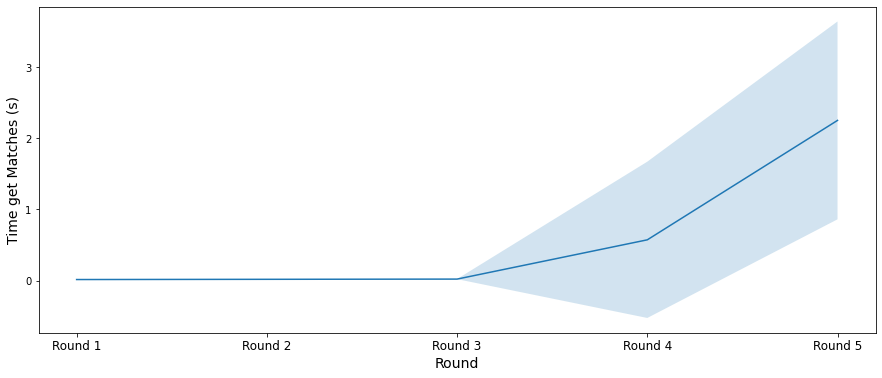

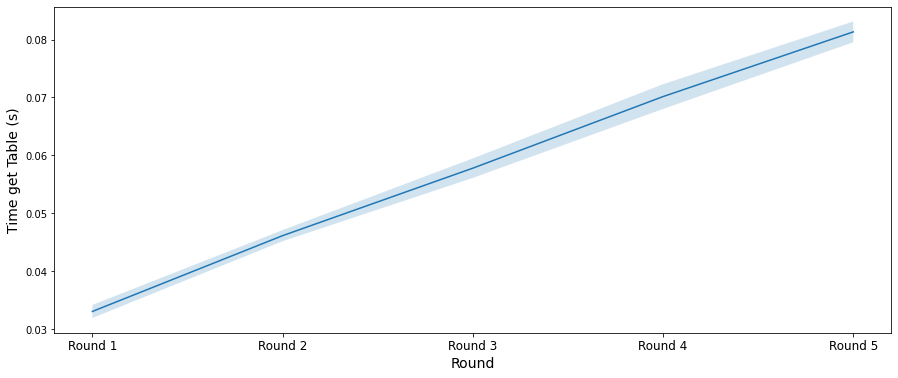

In [5]:
round_name = ["Round " + str(i+1) for i in range(num_of_rounds)]
round_num = [i for i in range(num_of_rounds)]


plt.figure(figsize=(15, 6))
plt.plot(round_num, np.mean(time_matches_list, axis=0))
plt.fill_between(round_num, 
                 np.mean(time_matches_list, axis=0)+np.std(time_matches_list, axis=0), 
                 np.mean(time_matches_list, axis=0)-np.std(time_matches_list, axis=0), 
                 alpha=0.2)
plt.xticks(round_num, round_name, fontsize=12)
plt.xlabel("Round", fontsize=14)
plt.ylabel("Time get Matches (s)", fontsize=14)

plt.show()

plt.figure(figsize=(15, 6))
plt.plot(round_num, np.mean(time_table_list, axis=0))
plt.fill_between(round_num, 
                 np.mean(time_table_list, axis=0)+np.std(time_table_list, axis=0), 
                 np.mean(time_table_list, axis=0)-np.std(time_table_list, axis=0), 
                 alpha=0.2)
plt.xticks(round_num, round_name, fontsize=12)
plt.xlabel("Round", fontsize=14)
plt.ylabel("Time get Table (s)", fontsize=14)

plt.show()